In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators.weight import WeightValidator

%matplotlib inline

## 1. Load Data
We load the portfolio data from the CSV file.

In [2]:
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions and {len(trades)} trades.")

Loaded 7721 positions and 468 trades.


## 2. Weight Validation
We verify that the reported 'Closing Weights' match the calculated weights based on Market Value.

In [3]:
validator = WeightValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} weight errors.")

# Convert errors to DataFrame for display
if errors:
    error_df = pd.DataFrame([vars(e) for e in errors])

    # Show distribution of severity
    print("Severity Distribution:")
    print(error_df["severity"].value_counts())

    cols = ['date', 'ticker', 'error_type', 'severity', 'description']
    display(error_df[cols])
else:
    print("No weight errors found.")

Found 6821 weight errors.
Severity Distribution:
severity
High      3640
Medium    1729
Low       1452
Name: count, dtype: int64


,date,ticker,error_type,severity,description
0,2022-01-03,ADBE,Weight Mismatch,Medium,Reported Weight 2.3680% vs Implied 5.5239%. Fl...
1,2022-01-03,ADE,Weight Mismatch,Medium,Reported Weight 1.9410% vs Implied 4.5270%. Fl...
2,2022-01-03,ADI,Weight Mismatch,High,Reported Weight 5.3170% vs Implied 12.4043%. F...
3,2022-01-03,AMAT,Weight Mismatch,Medium,Reported Weight 2.3920% vs Implied 5.5801%. Fl...
4,2022-01-03,AMC,Weight Mismatch,Low,Reported Weight -0.6390% vs Implied -1.4915%. ...
...,...,...,...,...,...
6816,2022-12-29,TLT,Weight Mismatch,High,Reported Weight 2.7130% vs Implied -51.5627%. ...
6817,2022-12-29,TQQQ,Weight Mismatch,High,Reported Weight -3.2580% vs Implied 61.9228%. ...
6818,2022-12-29,TSLA,Weight Mismatch,High,Reported Weight -0.7160% vs Implied 13.6154%. ...
6819,2022-12-29,URW_NL,Weight Mismatch,High,Reported Weight -5.0220% vs Implied 95.4438%. ...


## 3. Visualization
Let's visualize the discrepancy for the top errors.

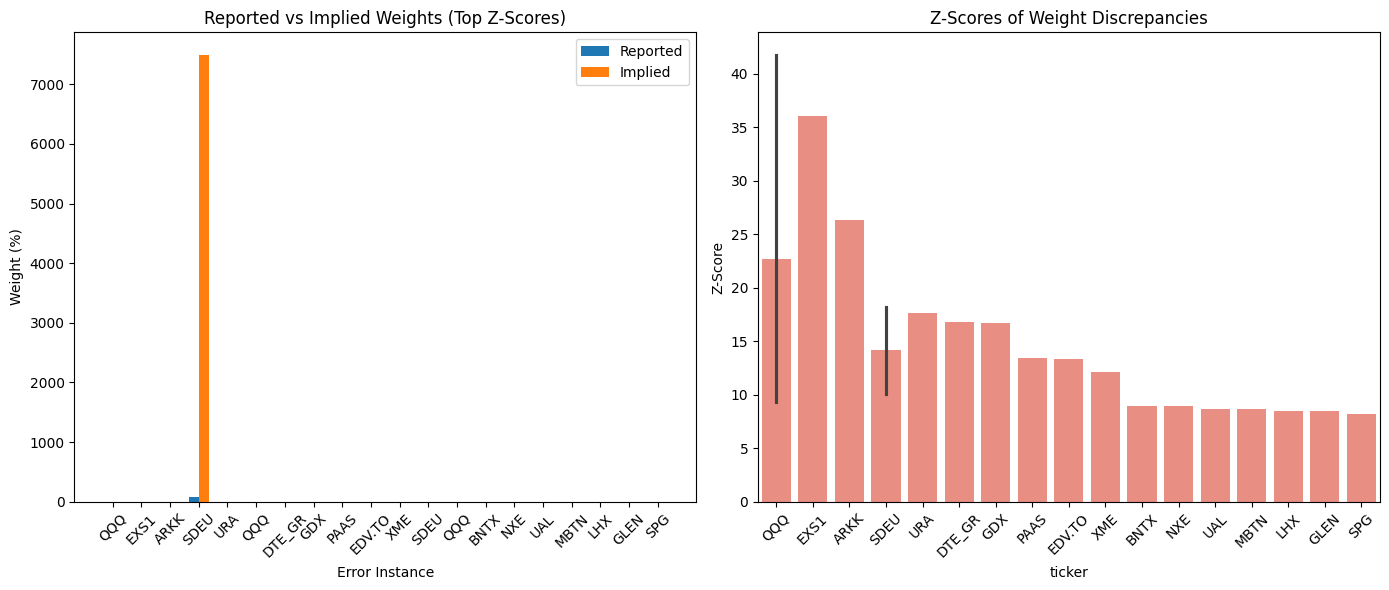

,date,ticker,Reported_Pct,Implied_Pct,Z_Score,severity
1390,2022-04-12,QQQ,0.000,0.0000,41.8,High
1379,2022-04-12,EXS1,0.000,0.0000,36.1,High
1374,2022-04-12,ARKK,0.000,0.0000,26.3,High
1598,2022-04-26,SDEU,72.073,7496.3069,18.2,High
1396,2022-04-12,URA,0.000,0.0000,17.6,High
1872,2022-05-13,QQQ,0.000,0.0000,17.0,High
1862,2022-05-13,DTE_GR,0.000,0.0000,16.8,High
1380,2022-04-12,GDX,0.000,0.0000,16.7,High
1389,2022-04-12,PAAS,0.000,0.0000,13.4,High
1378,2022-04-12,EDV.TO,0.000,0.0000,13.3,High


In [4]:
if errors:
    # Parse the description to extract Reported vs Implied and Z-Score
    # Description format: "Reported Weight 2.0000% vs Implied 2.5000%. Flagged due to: ... (Z=41.8)"
    import re
    
    def parse_error_details(desc):
        # Extract weights
        weights_match = re.search(r"Reported Weight ([\d\.]+)% vs Implied ([\d\.]+)%", desc)
        reported = float(weights_match.group(1)) if weights_match else 0.0
        implied = float(weights_match.group(2)) if weights_match else 0.0
        
        # Extract Z-score if present
        z_match = re.search(r"Z=([\d\.]+)", desc)
        z_score = float(z_match.group(1)) if z_match else 0.0
        
        return reported, implied, z_score

    error_df[['Reported_Pct', 'Implied_Pct', 'Z_Score']] = error_df['description'].apply(lambda x: pd.Series(parse_error_details(x)))
    
    # Sort by Z-Score descending to see the worst outliers
    top_errors = error_df.sort_values('Z_Score', ascending=False).head(20)
    
    if not top_errors.empty:
        # Plot 1: Weights Comparison
        plt.figure(figsize=(14, 6))
        
        # Subplot 1: Bar chart of weights
        plt.subplot(1, 2, 1)
        x = range(len(top_errors))
        width = 0.35
        
        plt.bar([i - width/2 for i in x], top_errors['Reported_Pct'], width, label='Reported')
        plt.bar([i + width/2 for i in x], top_errors['Implied_Pct'], width, label='Implied')
        
        plt.xlabel('Error Instance')
        plt.ylabel('Weight (%)')
        plt.title('Reported vs Implied Weights (Top Z-Scores)')
        plt.xticks(x, top_errors['ticker'], rotation=45)  # type: ignore
        plt.legend()
        
        # Subplot 2: Z-Scores
        plt.subplot(1, 2, 2)
        sns.barplot(x=top_errors['ticker'], y=top_errors['Z_Score'], color='salmon')
        plt.title('Z-Scores of Weight Discrepancies')
        plt.xticks(rotation=45)
        plt.ylabel('Z-Score')
        
        plt.tight_layout()
        plt.show()
        
        # Display the data
        display(top_errors[['date', 'ticker', 'Reported_Pct', 'Implied_Pct', 'Z_Score', 'severity']])

## 4. Time Series Analysis of Top Offenders
We visualize the full time series for the tickers with the most errors to understand the nature of the discrepancies (e.g., consistent offset, random spikes, or scaling issues).

Visualizing Weight Discrepancies for: RSX


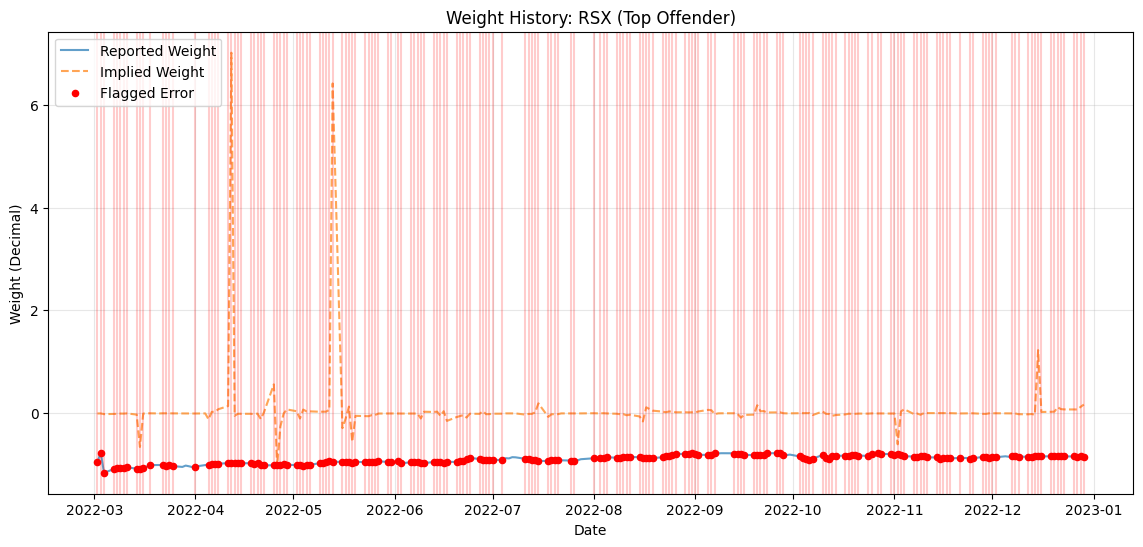

Visualizing Weight Discrepancies for: KSPI


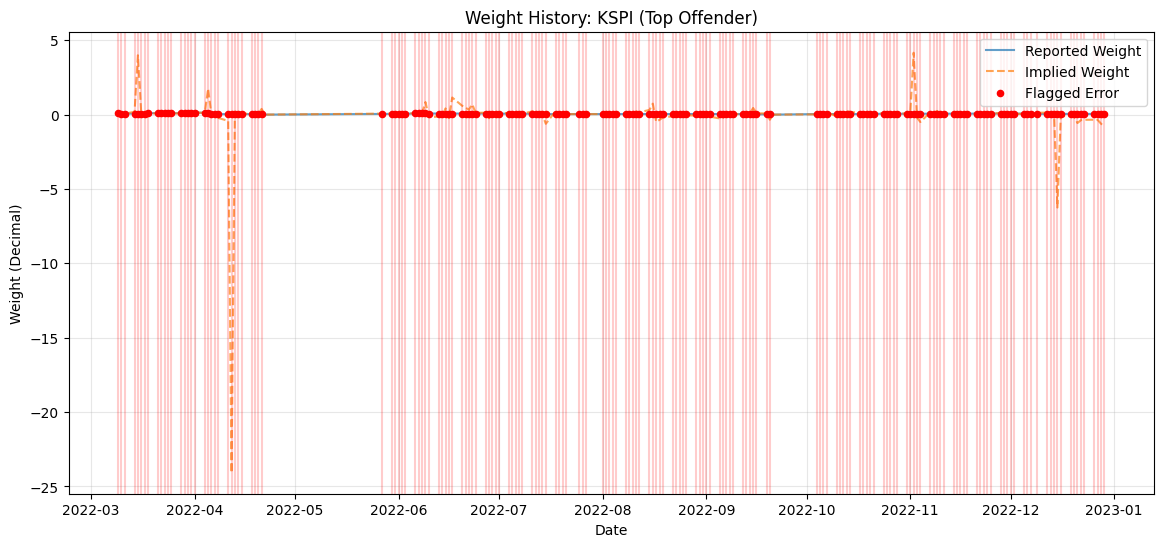

Visualizing Weight Discrepancies for: LDO_IT


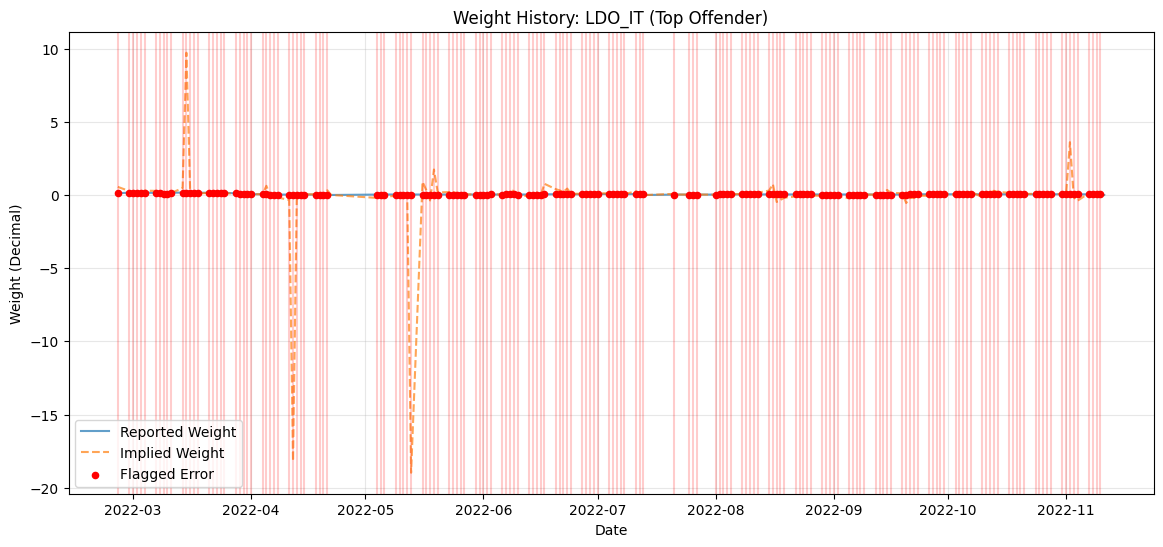

In [5]:
if errors:
    # 1. Identify top offenders (tickers with most errors)
    top_offenders = error_df['ticker'].value_counts().head(3).index.tolist()
    
    # Pre-calculate daily totals for the whole dataset to compute implied weights
    # Ensure numeric
    positions['Value in USD'] = pd.to_numeric(positions['Value in USD'], errors='coerce').fillna(0)
    daily_totals = positions.groupby('Date')['Value in USD'].transform('sum')
    positions['Implied_Weight_Calc'] = positions['Value in USD'] / daily_totals.replace(0, 1)
    
    for ticker in top_offenders:
        print(f"Visualizing Weight Discrepancies for: {ticker}")
        
        # Get full history for this ticker
        ticker_data = positions[positions['P_Ticker'] == ticker].sort_values('Date').copy()
        
        # Clean Closing Weights for plotting
        # Handle strings
        if ticker_data['Closing Weights'].dtype == 'object':
             ticker_data['Closing Weights'] = ticker_data['Closing Weights'].astype(str).str.replace('%', '').str.replace(',', '')
        ticker_data['Closing Weights'] = pd.to_numeric(ticker_data['Closing Weights'], errors='coerce')
        
        # Handle scaling (percentage vs decimal)
        # We use the median ratio of Closing/Implied to detect if Closing is ~100x Implied
        valid_ratio = ticker_data[ticker_data['Implied_Weight_Calc'].abs() > 0.0001]
        if not valid_ratio.empty:
            # Calculate ratio of Reported / Implied
            # If Reported is %, ratio should be ~100
            # If Reported is decimal, ratio should be ~1
            ratio = (valid_ratio['Closing Weights'] / valid_ratio['Implied_Weight_Calc']).abs().median()
            
            if 50 < ratio < 150: # It's likely percentage
                ticker_data['Closing Weights'] = ticker_data['Closing Weights'] / 100.0
        
        plt.figure(figsize=(14, 6))
        
        # Plot lines
        plt.plot(ticker_data['Date'], ticker_data['Closing Weights'], label='Reported Weight', alpha=0.7)
        plt.plot(ticker_data['Date'], ticker_data['Implied_Weight_Calc'], label='Implied Weight', linestyle='--', alpha=0.7)
        
        # Highlight errors
        ticker_errors = error_df[error_df['ticker'] == ticker]
        
        # Plot vertical lines for errors
        for _, err in ticker_errors.iterrows():
            plt.axvline(x=err['date'], color='red', alpha=0.2)
            
        # Scatter points for errors
        error_dates = ticker_errors['date']
        error_points = ticker_data[ticker_data['Date'].isin(error_dates)]
        plt.scatter(error_points['Date'], error_points['Closing Weights'], color='red', label='Flagged Error', zorder=5, s=20)

        plt.title(f"Weight History: {ticker} (Top Offender)")
        plt.xlabel("Date")
        plt.ylabel("Weight (Decimal)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()